# Figure 3: plots for the basin of attraction over a range of $N_m(0)$ and $N_w(0)$ values

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Importing required libraries

In [1]:
from scipy.optimize import fsolve
from scipy.integrate import odeint, solve_ivp
import numpy as np
import time
import pandas as pd
import sympy as sp
import math
import pylab as plt
import matplotlib
from sklearn import svm

Importing required scripts

In [2]:
import importlib
import Hughes_model

Hughes_ODEs = Hughes_model.Hughes_ODEs
F = Hughes_model.F_hughes   # change to F for alternative larval density function

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

Loading in data created in MATLAB
This corresponds to the parameter values in the main manuscript, $\phi=0.85$ and $v=1$.

In [3]:
# Load CSV file
res_detail = pd.read_csv('res_detail.csv')  # for Dye's larval density function, swap qu for dye

res_detail

,res_detail_new1_1,res_detail_new1_2,res_detail_new2_1,res_detail_new2_2,res_detail_new3,res_detail_new4,res_detail_new5_1,res_detail_new5_2
0,22.252683,18.063004,0,1,y1,0,22.252683,18.063004
1,8.008507,6.424743,0,1,y1,0,8.008507,6.765389
2,7.309911,20.182534,0,1,y1,0,7.309911,20.182534
3,4.936612,9.708189,0,1,y1,0,4.936612,9.708189
4,18.228230,19.028371,0,1,y1,0,18.228230,19.028371
...,...,...,...,...,...,...,...,...
995,1.338398,0.500576,0,1,y1,0,1.743414,6.765389
996,15.175962,22.176160,0,1,y1,0,15.175962,22.176160
997,28.547103,1.623432,1,0,y2,0,28.547103,1.623432
998,17.337572,7.287094,0,1,y1,0,17.337572,7.287094


Plotting the MATLAB data

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


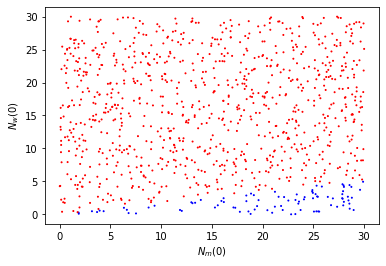

In [4]:
# Create a color map, blue for wildtype attracting, red for Wolbachia attracting
colors = ['red' if x == 'y1' else 'blue' for x in res_detail['res_detail_new3']]
# plot 
plt.scatter(res_detail['res_detail_new1_1'], res_detail['res_detail_new1_2'], c=colors, s=1)
plt.xlabel('$N_m(0)$')
plt.ylabel('$N_w(0)$')
plt.show()

Plotting the basin of attraction over the initial state conditions

(0.0, 30.0)

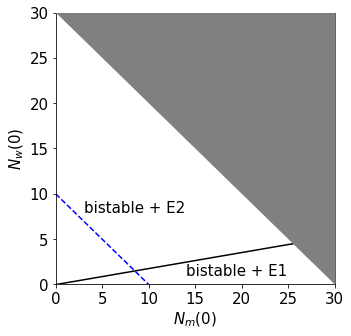

In [5]:

plt.figure(figsize=(5, 5)) # figure size
matplotlib.rcParams.update({'font.size': 15})  # font size

# Create a new column where 'y1' is 1 and other values are -1
res_detail['color'] = [1 if x == 'y1' else -1 for x in res_detail['res_detail_new3']]

# Fit the SVM model
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(res_detail[['res_detail_new1_1', 'res_detail_new1_2']], res_detail['color'])

# Get the separating hyperplane
w = clf.coef_[0]   # coefficients
a = -w[0] / w[1]
# x values
xx = np.linspace(min(res_detail['res_detail_new1_1']), 30)
# y values
yy = a * xx - (clf.intercept_[0]) / w[1]

# Plot the line
plt.plot(xx, yy, 'k-')
plt.plot(xx, 10-xx, 'b--')  # plot the line N_w(0) = 10 - N_m(0)

# fills in the quadrant above the household size boundary grey
# zorder command ensures grey shading brought to the front
xs = np.linspace(0,30,100)
plt.fill_between(xs,30.1-xs,np.max(xs),color='gray', zorder=10) 

plt.xlabel('$N_m(0)$')   # x label
plt.ylabel('$N_w(0)$')   # y label

plt.text(3,8,'bistable + E2',fontsize=15)   # add labels for Wolbachia or wild-type attracting
plt.text(14,1,'bistable + E1',fontsize=15)

plt.xlim(0,30) # x,y limits
plt.ylim(0,30)

#plt.savefig('contor_plot_qu_phi085.pdf', bbox_inches='tight')  # save figure

Calculating the proportion of Wolbachia-infected mosquitoes on the boundary

In [6]:
xvec = np.arange(0, 31, 1)
yvec = a * xvec - (clf.intercept_[0]) / w[1]
np.save('det_boundary.npy', yvec)   # save boundary values for later use
print('proportion of Wolbachia-infected mosquitoes on the boundary is', yvec/(xvec+yvec))

proportion of Wolbachia-infected mosquitoes on the boundary is [1.         0.13385357 0.14210661 0.14482279 0.14617443 0.14698337
 0.14752182 0.147906   0.14819391 0.14841771 0.14859666 0.14874302
 0.14886495 0.1489681  0.14905648 0.14913307 0.14920008 0.14925919
 0.14931173 0.14935873 0.14940102 0.14943929 0.14947407 0.14950583
 0.14953494 0.14956171 0.14958643 0.14960931 0.14963056 0.14965034
 0.14966881]


Solving for the coexistence steady state

In [7]:
# defining parameters as symbols so can solve symbolically
b,nm,nw,u,v,phi,Q,d,dw,h,k = sp.symbols('b nm nw u v phi Q d dw h k') 

zm = (nm*(nm + (1-v)*phi*nw) + nw*((1-u)*nm + (1-v)*phi*nw))/(nm + nw)
zw = v*phi*nw

eq1 = b*zm*sp.exp(-h*(nm+nw)**k) - d*nm   # ODE for wild-types
eq2 = b*phi*v*sp.exp(-h*(nm+nw)**k) - dw  # ODE for Wolbachia-infected, we have taken out a factor nw

### change to below for alternative larval density function
#eq1 = b*zm*(1-(nm + nw)/Q) - d*nm
#eq2 = b*phi*v*(1-(nm + nw)/Q) - dw  # have taken a factor of nw out

sol_coexist = sp.solve([eq1,eq2],[nm,nw])

Parameter values

In [8]:
days = 5000                  # no. of days in simulation
tStart, tEnd = 0, days       # start time and end time (days) of simulation

Q = 30        # reproductive carrying capacity
d = 12/100    # per capita death rate
phi = 8.5/10    # Wolbachia fitness
v = 10/10     # probability of vertical transmission
u = 10/10     # probability that infected male and uninfected female produce inviable offspring
delta = 1     # ratio of Wolbachia-infected death rate versus wild-type
dw = delta*d  # Wolbachia-infected birth rate

k = 0.3           # larval competition parameter
h = 0.19*100**k   # other larval competition parameter
b = round(d/F(10,h,k,Q),2)  # birth rate fitted for Dye's larval density function

tEval = np.linspace(tStart, tEnd)   # output points

In [9]:
print('wild-type SS is', ((np.log(d/b)/-h)**(1/k),0))
print('Wolbachia SS is', (0,(np.log(d*delta/(b*phi*v))/-h)**(1/k)))

nm_co = sol_coexist[1][0].subs({'b':b,'u':u,'v':v,'phi':phi,'Q':Q,'d':d,'dw':dw,'k':k,'h':h}).evalf()
nw_co = sol_coexist[1][1].subs({'b':b,'u':u,'v':v,'phi':phi,'Q':Q,'d':d,'dw':dw,'k':k,'h':h}).evalf()
print('coexistence SS is',(nm_co,nw_co))

wild-type SS is (9.886789309511753, 0)
Wolbachia SS is (0, 6.753361729430393)
coexistence SS is (5.74035747001583, 1.01300425941456)


For Figure 10 you will need to save the data from here and then run the code in 'Figure_10.ipynb'.

For Appendix Figure A2, change the larval density function and rerun the bSTAB code and then this notebook.